In [1]:
import findspark
findspark.init()


In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.sql import functions as f
import pyspark
from pyspark.ml.param import Param, Params
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import datetime
from pyspark.sql.functions import isnan


In [3]:
spark = SparkSession.builder.master("local[2]").appName("Google playstore app rating prediction").getOrCreate()

In [4]:
df = spark.read.format("csv").option("header",True).option("inferSchema",True).load("C:\\Users\\Jaisriram\\Desktop\\desktop\\bigdata\\examples\\googleplaystore.csv")

df.printSchema()
#df.show()
df.count()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



10841

In [5]:
df=df.dropDuplicates()
df.count()

10358

In [6]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()


+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|  1465|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [7]:
from pyspark.sql.types import IntegerType , FloatType
df = df.withColumn("Rating", df["Rating"].cast(FloatType()))
#df = df.withColumn("Type", df["Type"].cast(IntegerType()))
df.printSchema()
df.count()
#df.show(1000)

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



10358

In [8]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|  1467|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



10358

In [9]:
num_cols = [col_type[0] for col_type in filter(lambda dtype: dtype[1] in {"bigint", "double", "int","float"}, df.dtypes)]
### Compute a dict with <col_name, median_value>
median_dict = dict()
for c in num_cols:
   median_dict[c] = df.stat.approxQuantile(c, [0.5], 0.001)[0]
df = df.na.fill(median_dict)
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()
df.printSchema()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = t

In [10]:
df = df.withColumn('Size', translate('Size', 'M', ''))
df = df.withColumn('Size', translate('Size', 'k', ''))
df = df.withColumn('Size', translate('Size', '+', ''))
df = df.withColumn('Size', translate('Size', ',', ''))
#df_imputed = df_imputed.withColumn('Size', translate('Size', 'Varies with device', ''))
df = df.withColumn('Installs', translate('Installs', '+', ''))
df = df.withColumn('Installs', translate('Installs', ',', ''))
df = df.withColumn('Price', translate('Price', '$', ''))
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()
df.printSchema()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = t

In [11]:
df= df.where(col("Size") != "Varies with device")
#df_imputed.show(30)
df.count()

8833

In [12]:
df.show(10)
df.printSchema()

+--------------------+-------------------+------+-------+----+--------+----+-----+--------------+-----------------+------------------+-----------+------------+
|                 App|           Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|           Genres|      Last Updated|Current Ver| Android Ver|
+--------------------+-------------------+------+-------+----+--------+----+-----+--------------+-----------------+------------------+-----------+------------+
|English Dictionar...|BOOKS_AND_REFERENCE|   4.4| 341157|  30|10000000|Free|    0|  Everyone 10+|Books & Reference|    March 20, 2018|      3.9.1|  4.2 and up|
|Learn English for...|          EDUCATION|   4.5|   1929| 2.5|  500000|Free|    0|      Everyone|        Education|September 28, 2017|        1.1|  2.3 and up|
|Babbel – Learn Sp...|          EDUCATION|   4.4|  54798|  11| 1000000|Free|    0|      Everyone|        Education|     July 30, 2018|     20.7.2|  4.4 and up|
|Sarajevo Film Fes...|             EVENT

In [13]:
df = df.withColumn("Size", df["Size"].cast(FloatType()))
df = df.withColumn("Installs", df["Installs"].cast(FloatType()))
df = df.withColumn("Price", df["Price"].cast(FloatType()))
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- Installs: float (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [14]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   2|       1|   0|    3|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



8833

In [15]:
df=df.dropna(subset=("Type","Content Rating","Current Ver","Android Ver","Price","Size"))
df.count()

8829

In [16]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   0|    0|             0|     0|           0|          7|          2|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



8829

In [17]:
df=df.where(col("Current Ver") != "NaN")
df.count()

8822

In [18]:
df=df.where(col("Android Ver") != "NaN")
df.count()

8820

In [19]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   0|    0|             0|     0|           0|          0|          0|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



8820

In [20]:
df.registerTempTable("da1")
df = spark.sql('select * from da1 where App=="Infinite Painter"')
df.show()

+----------------+--------------+------+-------+----+---------+----+-----+--------------+------------+-------------+-----------+-----------+
|             App|      Category|Rating|Reviews|Size| Installs|Type|Price|Content Rating|      Genres| Last Updated|Current Ver|Android Ver|
+----------------+--------------+------+-------+----+---------+----+-----+--------------+------------+-------------+-----------+-----------+
|Infinite Painter|ART_AND_DESIGN|   4.1|  36815|29.0|1000000.0|Free|  0.0|      Everyone|Art & Design|June 14, 2018|   6.1.61.1| 4.2 and up|
+----------------+--------------+------+-------+----+---------+----+-----+--------------+------------+-------------+-----------+-----------+



In [21]:

df=spark.sql('select * from da1 where (Price > 0)')
df.show()

+-------------------------------+-------------------+------+-------+----+---------+----+-----+--------------+-----------------+-----------------+--------------------+------------+
|                            App|           Category|Rating|Reviews|Size| Installs|Type|Price|Content Rating|           Genres|     Last Updated|         Current Ver| Android Ver|
+-------------------------------+-------------------+------+-------+----+---------+----+-----+--------------+-----------------+-----------------+--------------------+------------+
|           Board Game Stats:...|          LIFESTYLE|   4.6|    275| 3.9|   5000.0|Paid| 2.99|      Everyone|        Lifestyle|    July 17, 2018|               2.8.3|  4.1 and up|
|             DW Contacts widget|              TOOLS|   4.3|     56| 2.0|   1000.0|Paid| 0.99|      Everyone|            Tools|     June 5, 2014|             1.1.0.0|  2.1 and up|
|RPG ブレイジング ソウルズ ア...|             FAMILY|   3.4|    159| 3.1|   1000.0|Paid|10.99|          Teen|  

In [22]:
df.filter(df["Price"].between(1, 3)).show(10)

+--------------------+---------+------+-------+----+--------+----+-----+--------------+---------+-----------------+-----------+------------+
|                 App| Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|   Genres|     Last Updated|Current Ver| Android Ver|
+--------------------+---------+------+-------+----+--------+----+-----+--------------+---------+-----------------+-----------+------------+
|Board Game Stats:...|LIFESTYLE|   4.6|    275| 3.9|  5000.0|Paid| 2.99|      Everyone|Lifestyle|    July 17, 2018|      2.8.3|  4.1 and up|
|          FJ Toolkit|    TOOLS|   4.3|      1| 2.5|   100.0|Paid| 1.49|      Everyone|    Tools|December 21, 2015|         14|  4.0 and up|
|FL Racing Manager...|   SPORTS|   4.3|    340|15.0|  5000.0|Paid| 1.99|      Everyone|   Sports|   March 17, 2018|       1.18|  3.0 and up|
|Muscle Trigger Po...|  MEDICAL|   4.4|   1361|33.0| 50000.0|Paid| 2.99|      Everyone|  Medical|    July 17, 2018|      2.4.4|4.0.3 and up|
|Whist - Tinn

In [23]:
df.groupby("Category").agg({'Installs': "sum"}).show()

spark.sql('select * from da1 where (Rating > 3)').show()

+-------------------+-------------+
|           Category|sum(Installs)|
+-------------------+-------------+
|             EVENTS|          1.0|
|             SPORTS|    1093815.0|
|            WEATHER|     311500.0|
|      VIDEO_PLAYERS|       1000.0|
|  AUTO_AND_VEHICLES|        150.0|
|          PARENTING|      50000.0|
|      ENTERTAINMENT|     100000.0|
|    PERSONALIZATION|    4047784.0|
|   TRAVEL_AND_LOCAL|      73060.0|
| HEALTH_AND_FITNESS|     224110.0|
|BOOKS_AND_REFERENCE|      18316.0|
|     FOOD_AND_DRINK|      50000.0|
|        PHOTOGRAPHY|    1728740.0|
|           BUSINESS|     212675.0|
|             FAMILY|  1.0723764E7|
|           SHOPPING|      10100.0|
|               GAME|  2.0899963E7|
|          EDUCATION|     602000.0|
|       PRODUCTIVITY|    1206055.0|
|              TOOLS|     446331.0|
+-------------------+-------------+
only showing top 20 rows

+--------------------+-------------------+------+-------+----+---------+----+-----+--------------+------------

In [24]:
df=spark.sql('select * from da1 where Type == "Free"')
df.show()

+--------------------+-------------------+------+-------+----+---------+----+-----+--------------+-----------------+------------------+------------+------------+
|                 App|           Category|Rating|Reviews|Size| Installs|Type|Price|Content Rating|           Genres|      Last Updated| Current Ver| Android Ver|
+--------------------+-------------------+------+-------+----+---------+----+-----+--------------+-----------------+------------------+------------+------------+
|English Dictionar...|BOOKS_AND_REFERENCE|   4.4| 341157|30.0|    1.0E7|Free|  0.0|  Everyone 10+|Books & Reference|    March 20, 2018|       3.9.1|  4.2 and up|
|Learn English for...|          EDUCATION|   4.5|   1929| 2.5| 500000.0|Free|  0.0|      Everyone|        Education|September 28, 2017|         1.1|  2.3 and up|
|Babbel – Learn Sp...|          EDUCATION|   4.4|  54798|11.0|1000000.0|Free|  0.0|      Everyone|        Education|     July 30, 2018|      20.7.2|  4.4 and up|
|Sarajevo Film Fes...|      

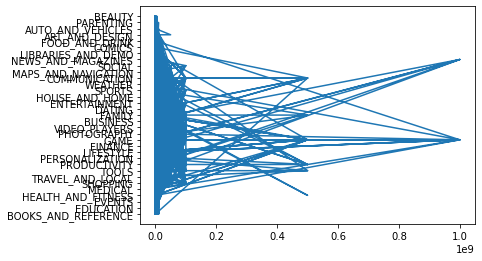

In [31]:
# PLOT PASSENGER NUMBER VS. TRIP COUNTS
#%%local
import matplotlib.pyplot as plt
import pandas
x=df.toPandas()["Installs"].values.tolist()
y=df.toPandas()["Category"].values.tolist()
plt.plot(x,y)
plt.show()

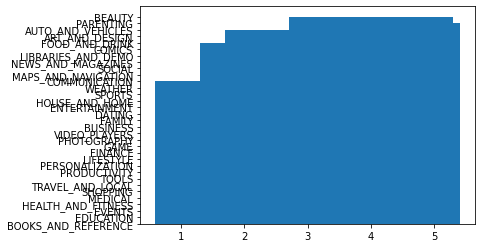

In [26]:
import matplotlib.pyplot as plt
import pandas
x=df.toPandas()["Rating"].values.tolist()
y=df.toPandas()["Category"].values.tolist()
plt.bar(x,y)
plt.show()

In [27]:
#import seaborn as sns
#test_df = df.toPandas()
#plt.figure(figsize=(7, 5))
#sns.heatmap(test_df.isnull(), cmap='viridis')
#test_df.isnull()

In [28]:
#import seaborn as sns
#test_df = df.toPandas()
#plt.figure(figsize=(7, 5))
#sns.heatmap(test_df.isnull(), cmap='viridis')
#test_df.isnull()